In [20]:
# PROCESS THE GLOBULAR CLUSTER STARS CATAOLOG:
# https://zenodo.org/records/4891252
#
#
# ZACK REEVES
# CREATED: 2024
#
# VERSIONS:
#  1.1  JAN 2024 CREATE JUPYTER NOTEBOOK

In [21]:
import pandas as pd
import numpy as np
import sys
import os
import collections

from tqdm import tqdm

from astropy.io import ascii
import astropy.units as u
import astropy.coordinates
from astropy.table import unique, vstack, Table, join

from astroquery.gaia import Gaia

sys.path.insert(0, '..')
from common import file_functions, calculations, gaia_functions, get_bailer_jones

from matplotlib import pyplot as plt, colors

In [22]:
# Define the metadata for the data set. #FIX LATER
metadata = {}

metadata['project'] = 'Digital Universe Atlas Gaia Subsets'
metadata['sub_project'] = 'Gaia Stars in Globular Clusters'

metadata['catalog'] = 'Catalogue of stars in Milky Way globular clusters from Gaia EDR3 (Vasiliev+, 2021)'
metadata['catalog_author'] = 'Vasiliev+'
metadata['catalog_year'] = '2021'
metadata['catalog_doi'] = 'https://doi.org/10.5281/zenodo.4891252'
metadata['catalog_bibcode'] = '10.5281/zenodo.4891252'

metadata['prepared_by'] = 'Brian Abbott, Zack Reeves'
metadata['version'] = '1.1'

metadata['dir'] = metadata['sub_project'].replace(' ', '_').lower()
metadata['raw_data_dir'] = ''

metadata['data_group_title'] = 'Gaia Globular Cluster Stars'
metadata['data_group_desc'] = 'Stars in the Milky Way identified to be members of globular clusters'
metadata['data_group_desc_long'] = ''
metadata['fileroot'] = 'globstars'

file_functions.generate_license_file(metadata)
file_functions.generate_asset_file(metadata)

In [23]:
#download data from https://zenodo.org/records/4891252

In [24]:
#reading in the data

#data are downloaded in a .zip file.  Once extracted, the stars associated with each cluster are stored in folders
#named by the cluster.  We combine each of these folders into one table with an appended column describing the
#cluster

#iterate through files in catalogues directory and stack

directory_str = 'clusters/catalogues/'
directory = os.fsencode(directory_str)
    
tables=[]
for file in tqdm(os.listdir(directory)):
    filename = os.fsdecode(file)
    if filename.endswith(".txt"):
        #reading in the table
        table = ascii.read(directory_str+filename)
        #adding a column with the cluster name
        table['cluster_name'] = table.Column(data=[filename[:len(filename)-4]]*len(table),
                                             meta = collections.OrderedDict([('ucd', 'meta.name.cluster')]),
                                             description='Name of associated Globular Cluster')
        #adding table to array for stacking
        tables.append(table)

100%|██████████| 170/170 [07:49<00:00,  2.76s/it]


In [25]:
#combining tables in tables array
data = vstack(tables)
data

source_id,ra,dec,x,y,plx,pmra,pmdec,plxe,pmrae,pmdece,pmcorr,g_mag,bp_rp,Sigma,qflag,memberprob,cluster_name
str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,str15
4829785385431810560,58.761525,-49.645388,0.0013,-0.0301,-0.7466,-0.2551,-2.6741,0.8455,0.6714,1.1889,0.071,20.6461,0.9471,1.059,3,0.9606,AM_1
4829785389727698688,58.751714,-49.646782,-0.0051,-0.0315,2.7071,4.6897,-25.359,0.1229,0.1314,0.1744,-0.1839,18.4849,2.6622,0.9764,3,0.0,AM_1
4829785385431812992,58.748515,-49.642957,-0.0072,-0.0277,1.1334,3.102,-3.0671,0.5935,0.6316,0.9969,-0.3091,20.5257,0.9007,1.146,2,0.00026,AM_1
4829785522870771200,58.711829,-49.639222,-0.0309,-0.024,0.7026,-2.8045,1.0433,0.8622,1.499,1.4694,-0.1802,20.7759,1.3373,0.7479,3,0.51338,AM_1
4829773947934874496,58.791386,-49.650119,0.0206,-0.0348,-0.0517,1.3742,-0.9804,0.3993,0.4761,0.5536,-0.1824,20.1028,0.6014,0.7152,3,0.91755,AM_1
4829774085373770624,58.816696,-49.634441,0.037,-0.0192,1.359,20.5965,20.4528,0.7439,0.7211,1.0011,-0.2158,19.2963,2.2922,0.688,0,0.0,AM_1
4829773982294556160,58.806048,-49.633596,0.0301,-0.0183,1.6977,7.9558,19.2337,0.0112,0.0126,0.0154,-0.1949,12.988,0.7496,0.8556,1,0.0,AM_1
4829785836404292992,58.803704,-49.627975,0.0286,-0.0127,1.4172,65.2717,-11.243,0.0255,0.0283,0.0372,-0.2458,15.6528,1.098,1.004,1,0.0,AM_1
4829785385431819648,58.750954,-49.638972,-0.0056,-0.0237,-0.2818,-0.0047,0.0801,0.2636,0.2863,0.3934,-0.2355,19.714,0.7056,1.514,3,0.99988,AM_1


In [26]:
data['source_id'] = [int(i) for i in data['source_id']]

In [27]:
#renaming columns 'x' and 'y' to not be confused with cartesian x and y and adding clarification
data.rename_column('x', 'cluster_x')
data['cluster_x'].description ='X coordinate centered on cluster'
data.rename_column('y', 'cluster_y')
data['cluster_y'].description ='Y coordinate centered on cluster'

#removing proper motion columns because we'll get them from Gaia DR3
data.remove_column('pmra')
data.remove_column('pmdec')

#removing rows with parallax <=0.0 and rows with memberprob < 0.5
data.remove_rows(np.where(data['plx']<=0.0)[0])
data.remove_rows(np.where(data['memberprob']<0.5)[0])

In [28]:
#data.write('gc.fits', overwrite=True)

In [29]:
#data = Table.read('gc.fits')

In [30]:
distances = get_bailer_jones.get_bj_distances(data, get_motion=True)

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
Sending pytable.
Uploaded table 'gaia_ids'.
INFO: Query finished. [astroquery.utils.tap.core]
Table 'gaia_ids' deleted.
Removed jobs: '1763155816446O'.
INFO: Gaia TAP server logout OK [astroquery.gaia.core]
INFO: Gaia data server logout OK [astroquery.gaia.core]


In [31]:
data = join(data, distances, keys='source_id', join_type='left')
data

source_id,ra,dec,cluster_x,cluster_y,plx,plxe,pmrae,pmdece,pmcorr,g_mag,bp_rp,Sigma,qflag,memberprob,cluster_name,parallax,parallax_error,pmra,pmdec,radial_velocity,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo,bj_distance,dcalc,e_bj_dist,bj_error_over_distance
,,,,,,,,,,,,,,,,mas,mas,mas / yr,mas / yr,km / s,pc,pc,pc,pc,pc,pc,pc,,pc,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,str15,float64,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64
159501547637156224,71.51138,31.350682,-0.0113,-0.0308,1.2437,0.6005,0.777,0.6146,0.2396,20.0605,2.1708,10.06,2,0.57425,Pal_2,1.243963963123851,0.6004813,1.0714211277035552,-1.3183192058131075,--,1894.8824,3319.195,1014.4835,2083.7034,2721.644,1819.6149,2083.7034,1,451.01458740234375,0.2164485569691977
159501586292411776,71.523145,31.355986,-0.0013,-0.0255,1.3454,0.9036,1.3053,0.9417,0.1647,20.4477,1.7141,13.89,2,0.7056,Pal_2,1.332067740578626,0.9035593,0.19450881760742672,-1.0074072002350758,--,1402.9673,2177.2969,875.86127,4151.568,4846.3735,3572.756,4151.568,1,636.8087158203125,0.15338993257324304
159501586292412288,71.516286,31.357777,-0.0071,-0.0237,0.2818,1.3668,1.8071,1.3501,0.3341,20.5715,2.0812,14.49,0,0.66133,Pal_2,0.25809036897508,1.3667847,2.287536528932165,1.1161745736258242,--,2487.9849,3831.4065,1254.0636,2878.1316,3601.5107,2550.4177,2878.1316,1,525.5465087890625,0.182599888860868
159501586292963200,71.525228,31.359972,0.0005,-0.0215,0.0346,0.3308,0.3755,0.3023,-0.0392,19.3274,2.6935,18.19,2,0.98728,Pal_2,0.016371028164813155,0.3307884,1.2813790091588988,-1.7047067727289518,--,4311.292,8385.011,2305.2332,1014.93994,1517.9391,883.3095,1014.93994,1,317.3147888183594,0.3126439071643036
159501586292964352,71.516123,31.3589,-0.0073,-0.0226,0.2237,0.3176,0.3701,0.2978,0.1035,19.2022,1.6768,15.42,3,0.97019,Pal_2,0.20870282125022963,0.31755328,1.1721832004023987,-1.7947624541203158,--,2382.0242,3542.7734,1687.5037,2864.8809,3847.298,2325.7483,2864.8809,1,760.77490234375,0.2655520210741748
159501650715977600,71.550888,31.3634,0.0224,-0.0181,0.0619,0.1532,0.1681,0.1328,0.1675,17.8953,2.5126,11.92,3,0.99651,Pal_2,0.027913769997799202,0.15324143,1.1892825433774734,-1.5618312656372937,--,4006.4885,5476.6,2829.8552,3335.1077,3696.4226,2477.0713,3335.1077,1,609.6756591796875,0.1828053904802578
159501650715980416,71.545134,31.365569,0.0175,-0.0159,0.1594,0.2282,0.2728,0.2196,0.1413,18.7062,2.2034,15.48,3,0.99148,Pal_2,0.13977026059604541,0.22822945,0.9328294585958732,-1.449334770999215,--,4049.8425,6042.531,2320.2788,2118.2573,2645.3796,1695.7231,2118.2573,1,474.8282470703125,0.22415985142194061
159501650715989504,71.556921,31.371705,0.0276,-0.0098,0.0901,0.1513,0.1776,0.1372,0.2521,18.039,2.4902,11.69,3,0.99657,Pal_2,0.0591514335376898,0.15125853,1.0626129493365912,-1.5901208026035942,--,3695.623,5187.964,2768.1565,3477.9958,4177.392,2442.3296,3477.9958,1,867.53125,0.24943423957720803


In [32]:
data['cluster_name'] = table.Column(data=data['cluster_name'],
                                         meta = collections.OrderedDict([('ucd', 'meta.name.cluster')]),
                                         description='Name of associated Globular Cluster')

In [33]:
#fixing parallax units
data['plx'].unit=u.mas

#fixing RA/Dec units
data['ra'].unit=u.deg
data['dec'].unit=u.deg

In [34]:
#calculating distance in light years and parsecs
calculations.get_distance(data, dist='bj_distance', use='distance')

In [35]:
#calculating cartesian coordinates
calculations.get_cartesian(data, ra='ra', dec='dec', pmra='pmra', pmde='pmdec', frame='icrs')

<function matplotlib.pyplot.show(close=None, block=None)>

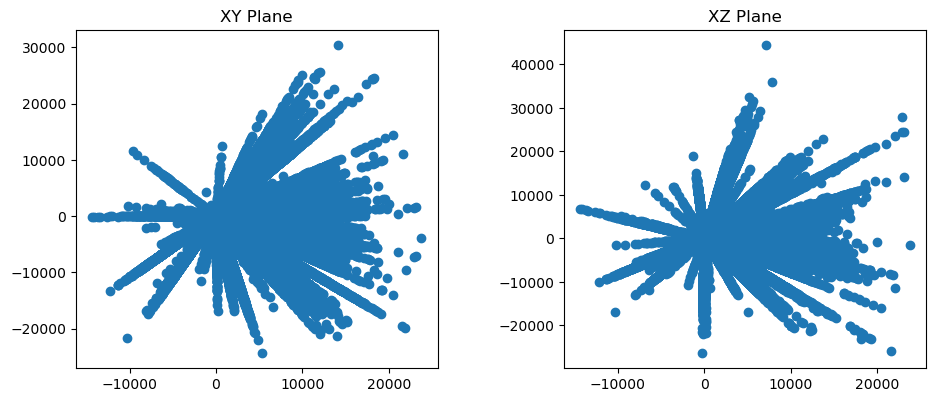

In [36]:
#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(data['x'], data['y'])
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(data['x'], data['z'])
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

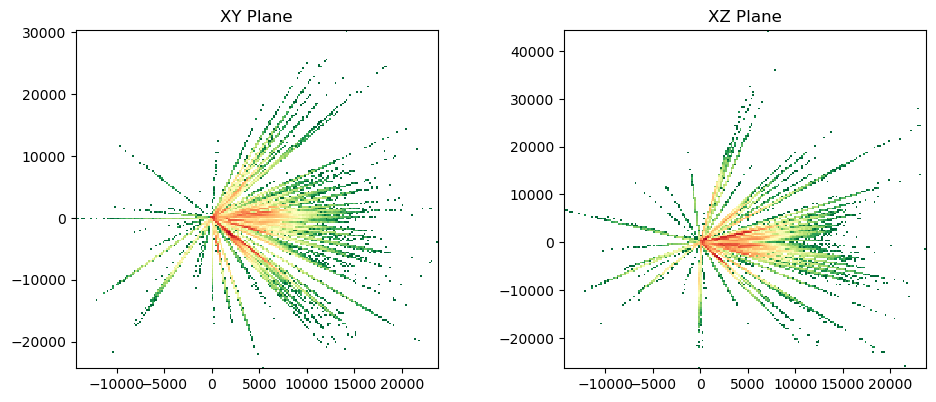

In [37]:
#2D Density Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].hist2d(data['x'], data['y'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].hist2d(data['x'], data['z'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
#plt.show

In [38]:
gaia_functions.get_magnitudes(data, gmag='g_mag')
gaia_functions.get_luminosity(data)
gaia_functions.get_bp_g_color(data, color='bp_rp')

In [39]:
#construct a speck comment column
data['speck_label'] = data.Column(data=['#__'+str(name) for name in data['source_id']], 
                                  meta=collections.OrderedDict([('ucd', 'meta.id')]),
                                  description='Gaia EDR3 Source ID')

#construct a label column
data['label'] = ['GaiaEDR3_'+ str(source) for source in data['source_id']]  #leaving for now in case we want to add other labels

#setting texture number column
data['texnum'] = data.Column(data=[1]*len(data), 
                                  meta=collections.OrderedDict([('ucd', 'meta.texnum')]),
                                  description='Texture Number')

In [40]:
#Getting the column metadata
columns = file_functions.get_metadata(data, columns=['x', 'y', 'z', 'color', 'lum', 'absmag', 'appmag', 'texnum', 'dist_ly', 'dcalc', 'u', 'v', 'w', 'speed', 'cluster_name', 'speck_label'])
columns

,name,unit,datatype,width,precision,arraysize,ucd,description
0,x,pc,float64,,6,,pos.cartesian.x,x position (galactic cartesian coordinates) in...
1,y,pc,float64,,6,,pos.cartesian.y,Position (y coordinate) in parsecs
2,z,pc,float64,,6,,pos.cartesian.z,Position (z coordinate) in parsecs
3,color,solLum,float64,,2,,phys.color,Gaia BP-G color
4,lum,solLum,float64,,6,,phys.luminosity,Stellar Luminosity
5,absmag,mag,float64,,6,,phot.magAbs;em.opt.G,Absolute magnitude in Gaia G-band
6,appmag,mag,float64,,6,,phot.mag;em.opt.G,Apparent magnitude in Gaia G-band
7,texnum,,int32,,,,meta.texnum,Texture Number
8,dist_ly,lyr,float32,,1,,pos.distance,Distance from Sun (lyr)
9,dcalc,,int32,,,,meta.dist,Distance indicator: 1 indicates a Bailer-Jones...


In [41]:
# Print the csv file using the to_speck function in file_functions
file_functions.to_csv(metadata, Table.to_pandas(data), columns)

# Print the speck file using the to_speck function in file_functions
file_functions.to_speck(metadata, Table.to_pandas(data), columns)

# Print the label file using the to_label function in file_functions
file_functions.to_label(metadata, Table.to_pandas(data))

In [42]:
cluster_names = unique(data, keys='cluster_name')['cluster_name']

In [43]:
for i in cluster_names:
    print(i)

AM_1
AM_4
Arp_2
BH_140
BH_176
BH_261_AL_3
Bliss_1
Crater
Djorg_1
Djorg_2_ESO456-
ESO280-06
ESO452-11
ESO_93-8
E_3
Eridanus
FSR_1716
FSR_1735
FSR_1758
Gran_1
HP_1_BH_229
IC_1257
IC_1276_Pal_7
IC_4499
Kim_3
Ko_1
Ko_2
Laevens_3
Liller_1
Lynga_7_BH184
Mercer_5
Munoz_1
NGC_104_47Tuc
NGC_1261
NGC_1851
NGC_1904_M_79
NGC_2298
NGC_2419
NGC_2808
NGC_288
NGC_3201
NGC_362
NGC_4147
NGC_4372
NGC_4590_M_68
NGC_4833
NGC_5024_M_53
NGC_5053
NGC_5139_oCen
NGC_5272_M_3
NGC_5286
NGC_5466
NGC_5634
NGC_5694
NGC_5824
NGC_5897
NGC_5904_M_5
NGC_5927
NGC_5946
NGC_5986
NGC_6093_M_80
NGC_6101
NGC_6121_M_4
NGC_6139
NGC_6144
NGC_6171_M107
NGC_6205_M_13
NGC_6218_M_12
NGC_6229
NGC_6235
NGC_6254_M_10
NGC_6256
NGC_6266_M_62
NGC_6273_M_19
NGC_6284
NGC_6287
NGC_6293
NGC_6304
NGC_6316
NGC_6325
NGC_6333_M_9
NGC_6341_M_92
NGC_6342
NGC_6352
NGC_6355
NGC_6356
NGC_6362
NGC_6366
NGC_6380_Ton1
NGC_6388
NGC_6397
NGC_6401
NGC_6402_M_14
NGC_6426
NGC_6440
NGC_6441
NGC_6453
NGC_6496
NGC_6517
NGC_6522
NGC_6528
NGC_6535
NGC_6539
NGC_654

In [44]:
print(cluster_names)

  cluster_name 
---------------
           AM_1
           AM_4
          Arp_2
         BH_140
         BH_176
    BH_261_AL_3
        Bliss_1
         Crater
        Djorg_1
Djorg_2_ESO456-
            ...
  Terzan_4_HP_4
    Terzan_5_11
  Terzan_6_HP_5
       Terzan_7
       Terzan_8
       Terzan_9
  Ton2_Pismis26
          UKS_1
      VVV_CL001
      VVV_CL002
      Whiting_1
Length = 170 rows


In [45]:
#the distances given for the stars in globular clusters are inaccurate due to local motions within the clusters
#we disect the dataset back into its constituent clusters to artificially constrain the stars in each cluster to the hypothetical cluster radius

In [53]:
from astroquery.vizier import Vizier
# #reading in the catalogue
catalog = Vizier(catalog='J/MNRAS/505/5978', columns=['**'], row_limit=-1).query_constraints()
clusters = catalog[0]
clusters

recno,Name,OName,RAJ2000,DEJ2000,pmRA,e_pmRA,pmDE,e_pmDE,corr,plx,e_plx,Rscale,Nstar,SimbadName
,,,deg,deg,mas / yr,mas / yr,mas / yr,mas / yr,,mas,mas,arcmin,,
int32,str12,str10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,str26
1,NGC 104,47 Tuc,6.024,-72.081,5.252,0.021,-2.551,0.021,0.00,0.232,0.009,10.03,39932,NGC 104
2,NGC 288,,13.188,-26.583,4.164,0.024,-5.705,0.024,0.01,0.141,0.011,2.79,4689,NGC 288
3,NGC 362,,15.809,-70.849,6.694,0.025,-2.535,0.024,0.00,0.114,0.011,3.37,3878,NGC 362
4,Whiting 1,,30.737,-3.253,-0.228,0.065,-2.046,0.056,0.03,0.017,0.047,0.52,40,Whiting 1
5,NGC 1261,,48.068,-55.216,1.596,0.025,-2.064,0.025,0.01,0.068,0.011,1.73,1218,NGC 1261
6,Pal 1,,53.333,79.581,-0.252,0.034,0.007,0.037,0.08,0.112,0.023,0.54,92,Pal 1
7,E 1,AM 1,58.760,-49.615,0.291,0.107,-0.177,0.086,-0.22,-0.015,0.062,0.36,58,E 1
8,Eridanus,,66.185,-21.187,0.510,0.039,-0.301,0.041,-0.09,0.050,0.033,0.52,44,NAME Eridanus Star Cluster


In [54]:
# The table read in the commented out code in the previous cell usefully provides the mean parallaxes of each cluster
# The cluster names in that table don't exactly match the ones we have, so the following table is a custom correlation table
cluster_names_col = cluster_names.data
clustable = Table.to_pandas(clusters)
clustable = clustable.assign(cluster_names_col=cluster_names_col)
clustable = clustable.rename(columns={'cluster_names_col': 'bonus_column'})
clustable.to_csv("globclusters.csv", index=False, encoding='utf-8')
clusters = Table.read('globclusters.csv')

In [55]:
def angle_radius(rscale_theta, distance):
    return distance*np.tan(rscale_theta)

In [56]:
import scipy.stats as stats

In [57]:
cluster_dataframes=[]
for i in tqdm(range(len(cluster_names))):
    cluster = cluster_names[i]
    df = data[data['cluster_name']==cluster]
    
    clusters['plx'].unit=u.mas
    
    cluster_parallax = clusters['plx'][clusters['bonus_column']==cluster]
    if(cluster_parallax>0):
        cluster_distance = (clusters['plx'][clusters['bonus_column']==cluster]).to(u.pc, equivalencies=u.parallax())[0]
    else:
        cluster_distance = sum(df['bj_distance']) / len(df)
        
    cluster_radius = angle_radius(clusters['Rscale'][clusters['bonus_column']==cluster], cluster_distance)
    
    #calculating percentiles of the distances of each star in the cluster; we will maintain these percentilesas we narrow the distribution down
    df['dist_percentile'] = [stats.percentileofscore(df['bj_distance'], df['bj_distance'][i], kind='weak') for i in range(len(df))]
    
    #dropping stars which are egregiously far from the cluster (higher than 5 sigma)
    #df.remove_rows(np.where((df['dist_percentile']<(1-0.999999426696856))|(df['dist_percentile']>0.999999426696856))[0])
    
    #mu is the desired distance (the center of the cluster) and sigma will be the adjusted stdev
    mu = cluster_distance
    #we want 95% of our stars within our calculated diameter, so 4*sigma=diameter -> sigma=radius / 2
    sigma = angle_radius(rscale_theta=14.62*u.arcmin, distance=5181.347*u.pc) / 2

    adjusted_distance_distribution = stats.norm(loc=mu, scale=sigma)

    # df['adjusted_distances'] = [adjusted_distance_distribution.ppf(i/100) for i in df['dist_percentile']]
    df['adjusted_distances'] = [adjusted_distance_distribution.ppf(df['dist_percentile'][i]/100) if((df['dist_percentile'][i]<100.0)&(df['dist_percentile'][i]>0.0)) else df['bj_distance'][i] for i in range(len(df))]

    df['adjusted_distances'].unit=u.pc
    
    calculations.get_distance(df, dist='adjusted_distances', use='distance')
    calculations.get_cartesian(df, ra='ra', dec='dec', pmra='pmra', pmde='pmdec', frame='icrs')
    cluster_dataframes.append(df)

100%|██████████| 170/170 [01:25<00:00,  1.99it/s]


In [58]:
adjusted_data = vstack(cluster_dataframes)

<function matplotlib.pyplot.show(close=None, block=None)>

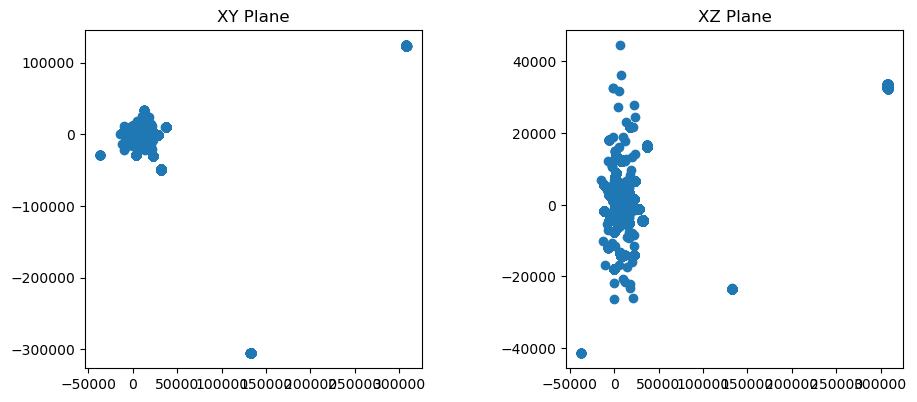

In [59]:
#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(adjusted_data['x'], adjusted_data['y'])
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(adjusted_data['x'], adjusted_data['z'])
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

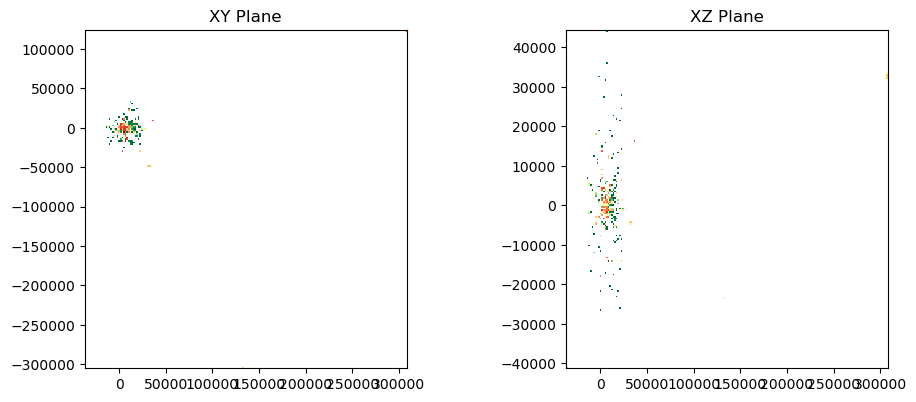

In [60]:
#2D Density Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].hist2d(adjusted_data['x'], adjusted_data['y'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].hist2d(adjusted_data['x'], adjusted_data['z'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
#plt.show

In [61]:
#Getting the column metadata
columns = file_functions.get_metadata(adjusted_data, columns=['x', 'y', 'z', 'color', 'lum', 'absmag', 'appmag', 'texnum', 'dist_ly', 'dcalc', 'u', 'v', 'w', 'speed', 'cluster_name', 'speck_label'])
columns

,name,unit,datatype,width,precision,arraysize,ucd,description
0,x,pc,float64,,6,,pos.cartesian.x,x position (galactic cartesian coordinates) in...
1,y,pc,float64,,6,,pos.cartesian.y,Position (y coordinate) in parsecs
2,z,pc,float64,,6,,pos.cartesian.z,Position (z coordinate) in parsecs
3,color,solLum,float64,,2,,phys.color,Gaia BP-G color
4,lum,solLum,float64,,6,,phys.luminosity,Stellar Luminosity
5,absmag,mag,float64,,6,,phot.magAbs;em.opt.G,Absolute magnitude in Gaia G-band
6,appmag,mag,float64,,6,,phot.mag;em.opt.G,Apparent magnitude in Gaia G-band
7,texnum,,int32,,,,meta.texnum,Texture Number
8,dist_ly,lyr,float64,,1,,pos.distance,Distance from Sun (lyr)
9,dcalc,,int32,,,,meta.dist,Distance indicator: 1 indicates a Bailer-Jones...


In [62]:
adjusted_data

source_id,ra,dec,cluster_x,cluster_y,plx,plxe,pmrae,pmdece,pmcorr,g_mag,bp_rp,Sigma,qflag,memberprob,cluster_name,parallax,parallax_error,pmra,pmdec,radial_velocity,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo,bj_distance,dcalc,e_bj_dist,bj_error_over_distance,dist_pc,dist_ly,x,y,z,u,v,w,speed,appmag,absmag,lum,color,speck_label,label,texnum,dist_percentile,adjusted_distances
,deg,deg,,,mas,,,,,,,,,,,mas,mas,mas / yr,mas / yr,km / s,pc,pc,pc,pc,pc,pc,pc,,pc,,pc,lyr,pc,pc,pc,km / s,km / s,km / s,,mag,mag,solLum,solLum,,,,,pc
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,str15,float64,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str22,str28,int32,float64,float64
4829785385431826048,58.749662,-49.633742,-0.0064,-0.0185,0.5788,0.6031,0.7837,0.8824,-0.4021,20.6074,0.8806,2.462,2,0.99192,AM_1,0.4681322953516981,0.60313386,-0.3001406871402359,-1.0911518571665653,--,1457.8054,2557.003,891.0842,10362.921,12448.18,8639.453,10362.921,1,1904.36328125,0.183767038262073,4322.350337,14097.6,-576.673148,-2807.033905,-3235.849374,nan,nan,nan,nan,20.607400,5.529990,0.476435,0.88,#__4829785385431826048,GaiaEDR3_4829785385431826048,1,86.20689655172413,4322.350336914899
4829785522870771200,58.711829,-49.639222,-0.0309,-0.024,0.7026,0.8622,1.499,1.4694,-0.1802,20.7759,1.3373,0.7479,3,0.51338,AM_1,0.6818278641397197,0.86221325,-2.804489364547545,1.0433419745212722,--,982.94684,1452.0437,637.2312,6032.3525,7025.5933,5129.314,6032.3525,1,948.1396484375,0.157175768872562,4307.945202,14050.6,-573.630029,-2796.635951,-3226.169217,nan,nan,nan,nan,20.775900,6.873466,0.138234,1.34,#__4829785522870771200,GaiaEDR3_4829785522870771200,1,41.37931034482759,4307.945202266323
4829785595884990336,58.744395,-49.627522,-0.0098,-0.0122,0.7118,0.5479,0.667,0.885,-0.1691,20.4633,0.9679,4.293,2,0.99748,AM_1,0.7958477423669105,0.54791147,0.04007342317495896,0.8103139386733293,--,1742.7523,2471.9785,1159.5659,8509.907,10016.891,7497.648,8509.907,1,1259.621337890625,0.14801822209752075,4314.744428,14072.8,-575.977451,-2801.744238,-3230.402247,nan,nan,nan,nan,20.463300,5.813676,0.366885,0.97,#__4829785595884990336,GaiaEDR3_4829785595884990336,1,65.51724137931033,4314.744427544411
4829785797748698880,58.773814,-49.623822,0.0092,-0.0085,0.5776,0.5022,0.5367,0.8287,-0.1124,20.4076,0.9997,7.67,2,0.99497,AM_1,0.5472766384229811,0.5022405,-0.5769094293469961,-1.6676006985974314,--,1436.0948,2044.4131,894.3575,7981.858,9429.968,6753.7153,7981.858,1,1338.126220703125,0.16764595859323314,4313.730468,14069.5,-576.676562,-2801.914516,-3228.775270,nan,nan,nan,nan,20.407600,5.897080,0.339757,1.00,#__4829785797748698880,GaiaEDR3_4829785797748698880,1,62.068965517241374,4313.730468171377
4829785797748706176,58.775161,-49.61823,0.0101,-0.003,1.438,0.9586,1.4045,1.892,-0.0475,20.8103,1.0239,12.07,3,0.99512,AM_1,1.4216420384737183,0.9585647,0.7797872283992997,0.9572793245917361,--,945.92426,1438.7612,620.81586,9523.648,11494.253,7822.605,9523.648,1,1835.823974609375,0.19276477776948336,4318.077811,14083.7,-577.665445,-2804.617157,-3232.061450,nan,nan,nan,nan,20.810300,5.916283,0.333800,1.02,#__4829785797748706176,GaiaEDR3_4829785797748706176,1,75.86206896551724,4318.077810962246
4829785797748718592,58.763598,-49.617819,0.0026,-0.0025,0.5746,0.5635,0.695,0.9459,-0.0141,20.4571,1.0252,71.92,2,0.99964,AM_1,0.5552477484368946,0.5635421,0.7628700611712264,-2.316518383985363,--,1208.4215,1859.1357,845.98553,7801.9277,9146.06,6516.1465,7801.9277,1,1314.95654296875,0.16854251766202613,4311.777326,14063.1,-576.621684,-2800.144692,-3227.711395,nan,nan,nan,nan,20.457100,5.996090,0.310144,1.03,#__4829785797748718592,GaiaEDR3_4829785797748718592,1,55.172413793103445,4311.77732623318
4829785797749159168,58.766973,-49.61703,0.0048,-0.0018,0.7983,0

In [63]:
# Print the csv file using the to_speck function in file_functions
file_functions.to_csv(metadata, Table.to_pandas(adjusted_data), columns)

# Print the speck file using the to_speck function in file_functions
file_functions.to_speck(metadata, Table.to_pandas(adjusted_data), columns)

# Print the label file using the to_label function in file_functions
file_functions.to_label(metadata, Table.to_pandas(adjusted_data))

In [64]:
max(adjusted_data['dist_pc'])

333371.3800829817

In [65]:
adjusted_data[adjusted_data['dist_pc']>300000]

source_id,ra,dec,cluster_x,cluster_y,plx,plxe,pmrae,pmdece,pmcorr,g_mag,bp_rp,Sigma,qflag,memberprob,cluster_name,parallax,parallax_error,pmra,pmdec,radial_velocity,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo,bj_distance,dcalc,e_bj_dist,bj_error_over_distance,dist_pc,dist_ly,x,y,z,u,v,w,speed,appmag,absmag,lum,color,speck_label,label,texnum,dist_percentile,adjusted_distances
,deg,deg,,,mas,,,,,,,,,,,mas,mas,mas / yr,mas / yr,km / s,pc,pc,pc,pc,pc,pc,pc,,pc,,pc,lyr,pc,pc,pc,km / s,km / s,km / s,,mag,mag,solLum,solLum,,,,,pc
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,str15,float64,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str22,str28,int32,float64,float64
5237105068584982528,169.966347,-65.221202,0.0175,-0.0015,0.0857,0.1782,0.2078,0.1864,0.0305,18.8938,2.0048,79.62,3,0.79814,ESO_93-8,0.059926447377858724,0.17814988,-4.357509544068819,1.6423004809248254,--,6869.581,12064.907,4328.366,2834.0227,6813.0977,1667.8173,2834.0227,1,2572.64013671875,0.9077697691373402,333321.005047,1087147.7,132714.347740,-304859.863674,-23457.575115,nan,nan,nan,nan,18.893800,6.631783,0.172698,2.00,#__5237105068584982528,GaiaEDR3_5237105068584982528,1,13.157894736842104,333321.0050466675
5237105206037934976,169.97789,-65.202903,0.0224,0.0168,0.0044,0.1984,0.2193,0.2047,0.1276,19.0794,1.0119,79.54,3,0.55846,ESO_93-8,-0.021139537472288587,0.19841887,-3.623004552124885,1.3415639697993484,--,7819.057,11548.615,5039.801,8428.503,10177.217,6789.6816,8428.503,1,1693.767578125,0.20095710854641646,333345.218555,1087226.7,132717.401087,-304893.271306,-23349.931359,nan,nan,nan,nan,19.079400,4.450648,1.287481,1.01,#__5237105206037934976,GaiaEDR3_5237105206037934976,1,85.96491228070175,333345.21855494473
5237115307784130304,169.936251,-65.240536,0.0049,-0.0208,0.025,0.1354,0.1537,0.1379,0.1053,18.5473,1.9481,78.95,2,0.89302,ESO_93-8,-0.001973010925331229,0.1353809,-3.8146950082514235,1.5694040663429438,--,6719.1865,11205.076,4451.148,6576.6787,8031.102,5242.3623,6576.6787,1,1394.369873046875,0.21201733189853647,333337.552577,1087201.7,132689.991242,-304878.388492,-23589.370766,nan,nan,nan,nan,18.547300,4.457267,1.279655,1.95,#__5237115307784130304,GaiaEDR3_5237115307784130304,1,64.91228070175438,333337.55257706693
5237115307795535104,169.924012,-65.231692,-0.0002,-0.012,0.3847,0.2022,0.2285,0.2055,0.1641,19.1078,1.5435,109.0,3,0.84143,ESO_93-8,0.36090709802423676,0.20217131,-4.433924674603623,1.2326376778999926,--,4576.8066,7886.2256,3028.637,3624.3489,5409.3887,2773.0728,3624.3489,1,1318.157958984375,0.3636951087590962,333323.781495,1087156.8,132643.536221,-304886.542993,-23550.615935,nan,nan,nan,nan,19.107800,6.311650,0.231921,1.54,#__5237115307795535104,GaiaEDR3_5237115307795535104,1,19.298245614035086,333323.7814952912
5237115312101265280,169.925332,-65.237308,0.0003,-0.0176,0.4639,0.6495,0.88,0.6154,-0.0035,20.3864,1.5963,79.55,2,0.54158,ESO_93-8,0.5179678965625824,0.6495056,-3.308052753259428,1.3038458815145697,--,4853.1367,8992.441,2412.0427,5379.784,6843.5977,4615.8267,5379.784,1,1113.885498046875,0.2070502200167402,333332.119605,1087184.0,132659.204076,-304886.520907,-23580.646792,nan,nan,nan,nan,20.386400,6.732576,0.157387,1.60,#__5237115312101265280,GaiaEDR3_5237115312101265280,1,45.614035087719294,333332.1196047481
5237115342143890816,169.955789,-65.228075,0.0131,-0.0084,0.1157,0.0853,0.0931,0.0934,0.125,17.6998,1.8864,89.05,3,0.97701,ESO_93-8,0.08809273576590242,0.08531552,-4.192220505029488,1.4997467700646727,--,6472.3325,9815.085,4752.281,6063.6685,12561.251,4722.515,6063.6685,1,3919.367919921875,0.6463690994478916,333336.024673,1087196.7,132709.616394,-304874.696070,-23504.951769,nan,nan,nan,nan,17.699800,3.786123,2.374383,1.89,#__5237115342143890816,GaiaEDR3_5237115342143890816,1,59

In [66]:
1000/0.003

333333.3333333333

In [67]:
clusters[clusters['bonus_column']=='NGC_2419']

recno,Name,OName,RAJ2000,DEJ2000,pmRA,e_pmRA,pmDE,e_pmDE,corr,plx,e_plx,Rscale,Nstar,SimbadName,bonus_column
,,,,,,,,,,mas,,,,,
int32,str12,str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,str26,str15
37,AM 4,--,209.09,-27.167,-0.291,0.445,-2.512,0.344,-0.36,0.079,0.343,0.39,8,AM 4,NGC_2419
